### Introduction to Qiskit

#### Ritajit Majumdar, Research Scientist, IBM Quantum

**A brief review**

1. Qubits: A *normalized* column vector $\quad$
    $|0> = \begin{pmatrix} 1\\ 0 \end{pmatrix}$
    $|1> = \begin{pmatrix} 0\\ 1 \end{pmatrix}$ $\quad$ $|\psi> = \begin{pmatrix} \alpha \\ \beta \end{pmatrix} = \alpha|0> + \beta|1>$.

2. Measurement: Qubit collapses to $|0>$ or $|1>$; $\quad$ measure $|\psi>$ $\Rightarrow$ $|0>$ with probability $|\alpha|^2$, $|1>$ with probability $|\beta|^2$ $\Rightarrow$ $|\alpha|^2 + |\beta|^2 = 1$.

3. Gates: Quantum gates are unitary operators $U|\psi> = |\phi>$. Action of any quantum gate is a rotation on the Bloch sphere.

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram, plot_bloch_multivector

### The first quantum circuit

We can define the number of quantum and classical registers that we want. A quantum register is a qubit, and a classical register is a bit that will hold the measurement outcome of the qubit. A QuantumCircuit is an object that takes the quantum and classical registers.

In [6]:
# initialize a quantum circuit with 2 qubits and 2 cbits

qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr,cr)

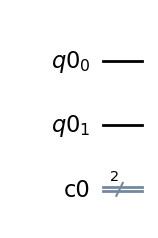

In [7]:
qc.draw('mpl')

All qubits are initialized in |0>. In the Bloch sphere representation, this is the north pole. This is a 2-qubit system, so there should be two Bloch spheres, one for each qubit -- both of them pointing to the north pole.

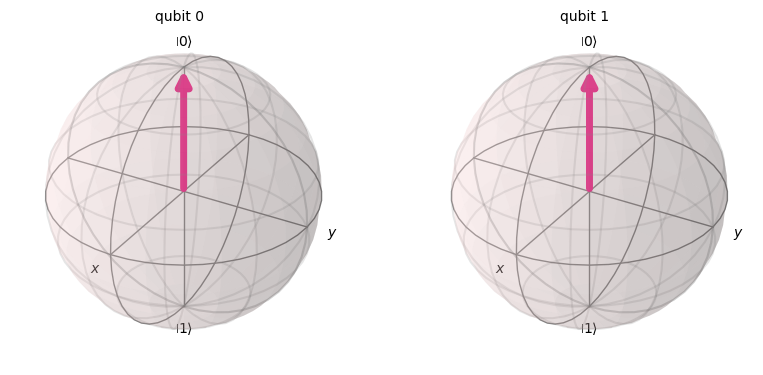

In [8]:
plot_bloch_multivector(qc)

Let us now measure the qubits. Since the qubits are in state |00>, the outcome should be 00 itself with probability 1.

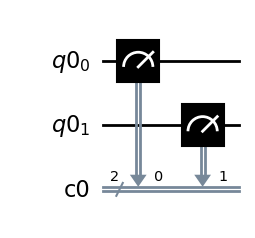

In [9]:
qc.measure(qr,cr)
qc.draw('mpl')

In order to execute the circuit, we need to define a backend to run the circuit. We shall use Qiskit Runtime for execution.

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler

If you are using Runtime for the first time, then you need to save your account details. That can be done as

QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")

In [11]:
service = QiskitRuntimeService()

First we shall use a simulator to run our circuit. A simulator is a great way to execute small circuits to verify its correctness before running on real quantum hardware.

In [12]:
simulator = service.get_backend('ibmq_qasm_simulator')

Qiskit Runtime provides two primitives for ease of use. The Sampler is a primitive used to execute a quantum service and get the output distribution.

In [13]:
sampler = Sampler(backend=simulator)

In [14]:
job = sampler.run(qc)

In [15]:
job.job_id()

'cl2dbalmc0adi9t7l550'

In [16]:
result = job.result()
result

SamplerResult(quasi_dists=[{0: 1.0}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])

In [17]:
counts = result.quasi_dists[0].binary_probabilities()

In [18]:
counts

{'00': 1.0}

Next we apply X gate on the first qubit. So the first qubit is flipped to 1, the second qubit remains 0.

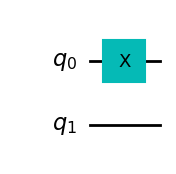

In [19]:
qc = QuantumCircuit(2)
qc.x(0)
qc.draw('mpl')

Let us verify our notion using Bloch sphere.

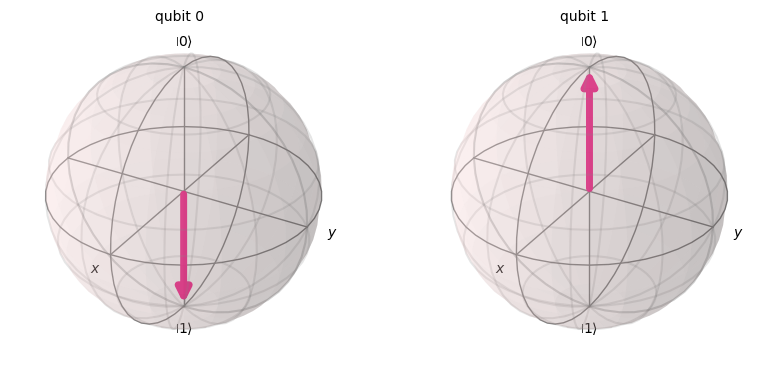

In [20]:
plot_bloch_multivector(qc)

When we measure these two qubits, the first qubit should collapse to 1, and the second to 0, with probability 1.

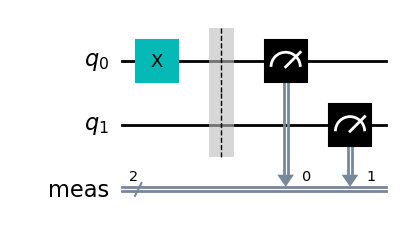

In [21]:
qc.measure_all()
qc.draw('mpl')

In [22]:
job = sampler.run(qc)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

Remember that Qiskit uses Little Endian

In [23]:
counts

{'01': 1.0}

Now we apply H gate on both the qubits. This should create an equal superposition of all the 4 states.

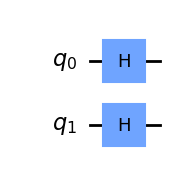

In [24]:
qc = QuantumCircuit(2)
qc.h(range(2))
qc.draw('mpl')

Let us check how this looks in the Bloch sphere representation.

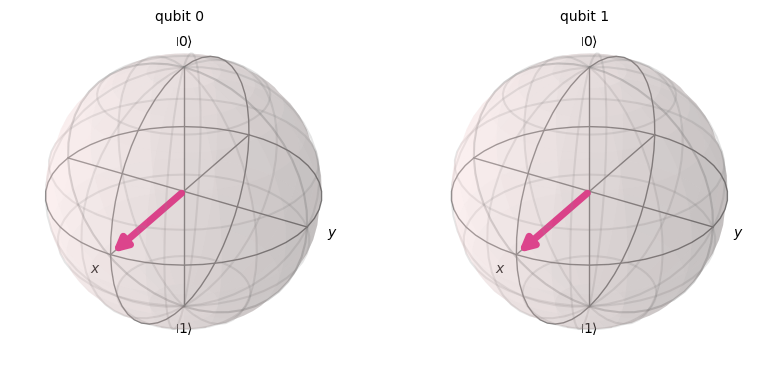

In [25]:
plot_bloch_multivector(qc)

In [27]:
qc.measure_all()

job = sampler.run(qc)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

In [28]:
counts

{'01': 0.2525, '11': 0.24725, '00': 0.24375, '10': 0.2565}

It is often useful to have a visual interpretation of the output distribution. You can get such a visualization by calling plot_histogram function from qiskit_visualization.

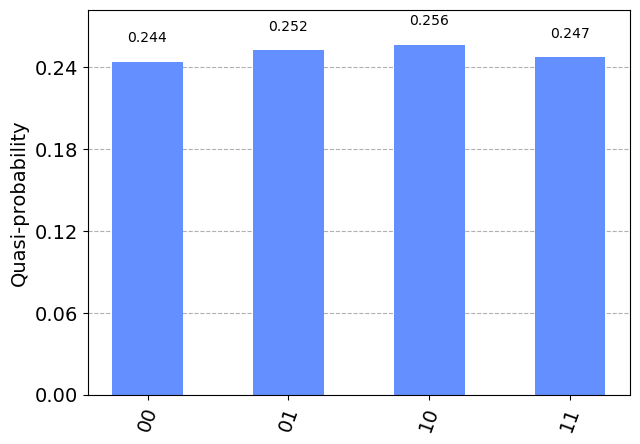

In [29]:
plot_histogram(counts)

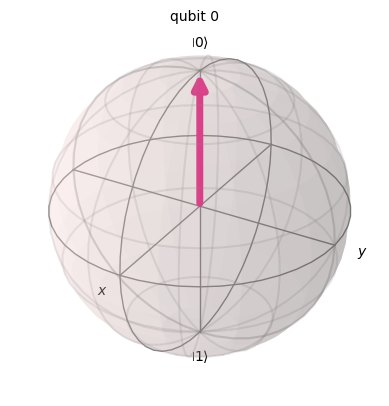

In [37]:
import numpy as np

qc = QuantumCircuit(1)
qc.rz(2*np.pi,0)

plot_bloch_multivector(qc)

s, sdg, x, y, z, h, rx, ry, rz, t, tdg, u1, u2, u3

We can define our own unitary operator as well

In [38]:
np.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

matrix([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]])

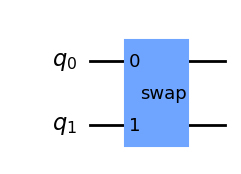

In [42]:
import qiskit.quantum_info as qi
import numpy as np

qc = QuantumCircuit(2)
swap = np.matrix([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
qc.unitary(qi.Operator(swap),[0,1],label='swap')
qc.draw('mpl')

We can define a controlled version of any unitary very easily

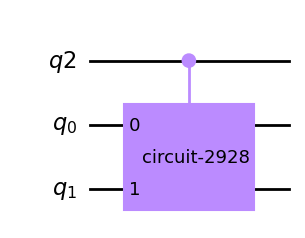

In [43]:
ctrl_swap = qc.control()
ctrl_swap.draw('mpl')

The controlled swap operation should swap the two qubits if the control is 1. In order to verify this, we create a 3-qubits circuit with the control qubit as 1, and the other two qubits in states 1 and 0 respectively. In other words, the initial state is 110. So after applying controlled-swap, we should have the outcome 101.

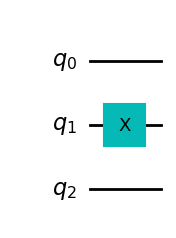

In [48]:
circ = QuantumCircuit(3)
circ.x(1)
circ.draw('mpl')

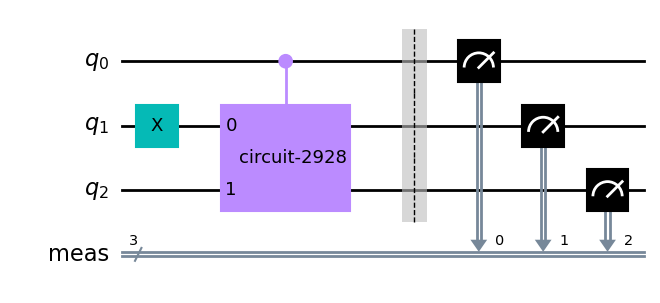

In [49]:
circ.compose(ctrl_swap,qubits=[0,1,2],inplace=True)
circ.measure_all()
circ.draw('mpl')

In [50]:
job = sampler.run(circ)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

In [51]:
counts

{'010': 1.0}

### Looking into the statevector

In [52]:
from qiskit import Aer, execute

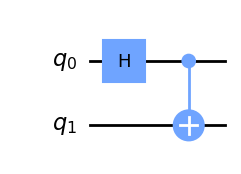

In [53]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl')

The above circuit creates the maximally entangled state $\frac{1}{\sqrt{2}}(|00>+|11>)$.

The statevector form of the circuit is $\begin{pmatrix}
\frac{1}{\sqrt{2}} \\ 0 \\ 0 \\ \frac{1}{\sqrt{2}}
\end{pmatrix}$

In [54]:
backend_sv = Aer.get_backend('statevector_simulator')
sv = execute(qc,backend_sv).result().get_statevector(qc)
sv

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


#### Food for thought. What should the Bloch sphere representation of the maximally entangled state look like?

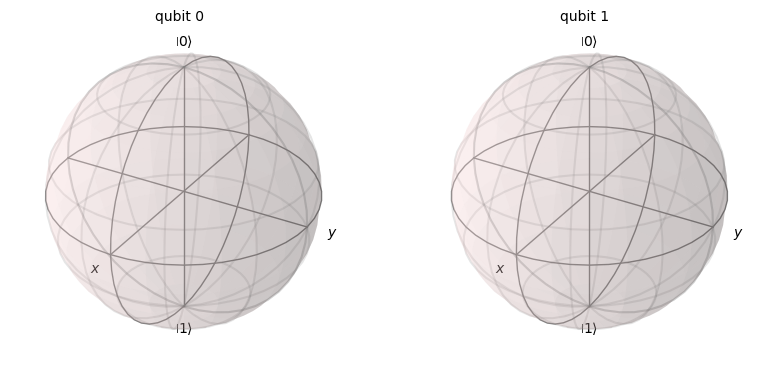

In [55]:
plot_bloch_multivector(qc)

We can get the probability distribution from the statevector.

In [56]:
sv.probabilities_dict()

{'00': 0.5000000000000001, '11': 0.4999999999999999}

The above method of execution is the mathematical approach where we obtain the state $\alpha|0> + \beta|1>$ via multiplying the matrices corresponding to the gate unitaries, and the probability is calculated as $p(0) = |\alpha|^2$ and $p(1) = |\beta|^2$. This calculation does not have statistical (shot) noise. But such a calculation is costly and cannot be performed for larger systems.

The statistical (shot) noise arises from the number of times we get the outcome. Each trial leads to a (potentially) different outcome, and we obtain a histogram of outcomes after some trials. We can change the value of shots and experiment.

In [57]:
options = Options()
options.execution.shots = 10
sampler = Sampler(backend=simulator, options=options)

In [58]:
qc.measure_all()

In [59]:
job = sampler.run(qc)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

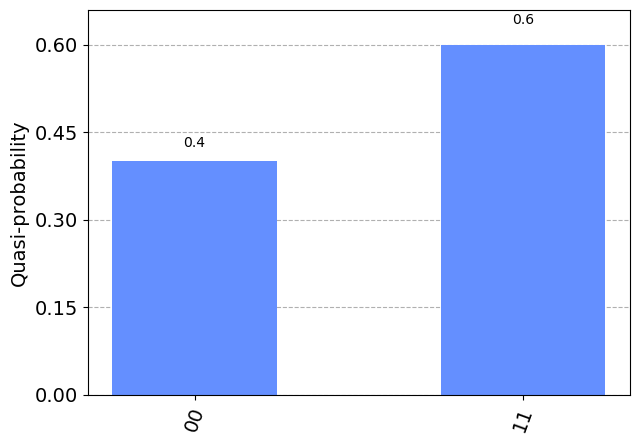

In [60]:
plot_histogram(counts)

In [61]:
options.execution.shots = 10000
sampler = Sampler(backend=simulator, options=options)

In [62]:
job = sampler.run(qc)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

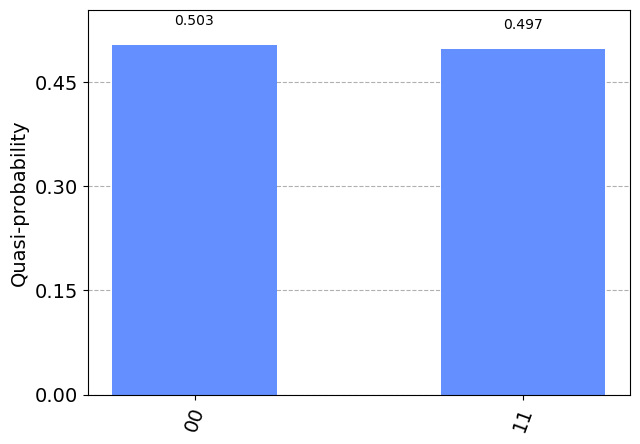

In [63]:
plot_histogram(counts)

### Initialize the qubit to arbitrary state

By default, qubits are initialized in the state |0>. But we can initialize a qubit in any arbitrary state as required. For example, let us initialize a qubit in the state $\frac{\sqrt{3}}{2}|0> + \frac{1}{2}|1> = \begin{pmatrix} \frac{\sqrt{3}}{2}\\ \frac{1}{2}\end{pmatrix}$

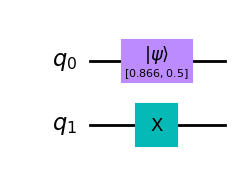

In [72]:
qc = QuantumCircuit(2)
qc.initialize([np.sqrt(3)/2,1/2],0)
qc.x(1)
qc.draw('mpl')

Let us measure this and verify the outcome

In [70]:
qc.measure_all()

job = sampler.run(qc)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

In [71]:
counts

{'1': 0.2482, '0': 0.7518}

We can initialize more than one qubits as well. For example, let us initialize a 2-qubit circuit in the state $\frac{1}{\sqrt{2}}|01> - \frac{i}{\sqrt{2}}|10>$. What should be the probabilities of obtaining $01$ and $10$? $\begin{pmatrix}0\\ \frac{1}{\sqrt{2}}\\ - \frac{i}{\sqrt{2}}\\ 0 \end{pmatrix}$

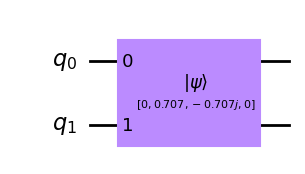

In [95]:
qc = QuantumCircuit(2)
qc.initialize([0,1/np.sqrt(2),-1j/np.sqrt(2),0],qc.qubits)
qc.draw('mpl')

Let us measure and verify the outcome

In [96]:
qc.measure_all()

job = sampler.run(qc)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

In [94]:
counts

{'11': 0.0219, '01': 0.4656, '00': 0.0241, '10': 0.4884}

### Running on a real device

Real hardware have queues. We may specify a particular hardware to run on by *service.get_backend(BACKEND_Name)*. You can use the least_busy method to find the hardware with the minimum queue.

##### backend = service.least_busy(operational=True, min_num_qubits=5, simulator=False)

In [76]:
backend = service.get_backend('ibmq_manila')

In [97]:
options.resilience_level = 1
sampler = Sampler(backend=backend, options=options)

In [98]:
job = sampler.run(qc)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

In [99]:
result.quasi_dists[0]

{0: -0.0023756560646698535,
 1: 0.5142589984639334,
 2: 0.4867506560646698,
 3: 0.0013660015360666192}

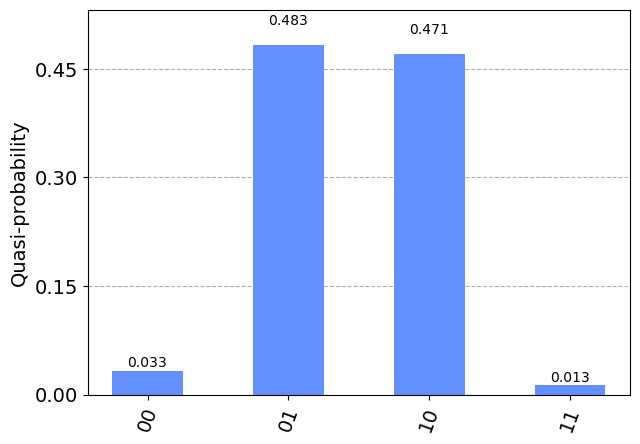

In [79]:
plot_histogram(counts)

The real backends often have a lot of queue. So it is useful to first test out the performance of your favourite quantum circuit in a noisy simulator.

In [80]:
from qiskit_aer.noise import NoiseModel

In [81]:
noise_model = NoiseModel.from_backend(backend)

In [82]:
options.simulator.noise_model = noise_model
sampler = Sampler(backend=simulator, options=options)

In [83]:
job = sampler.run(qc)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

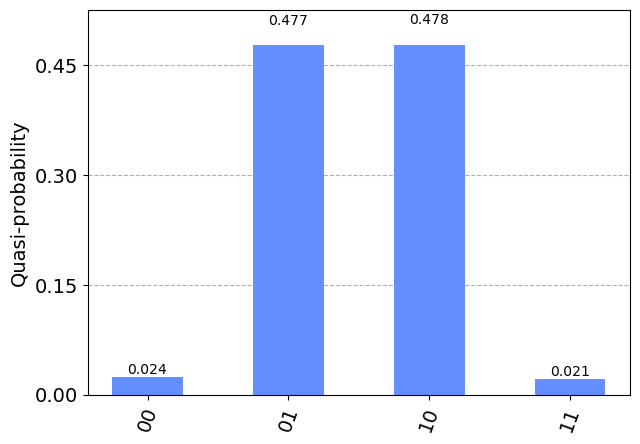

In [84]:
plot_histogram(counts)

### QSphere: An IBM Quantum development. Good to visualize multi qubit states

First we check for the Bell state

In [85]:
from qiskit.visualization import plot_state_qsphere

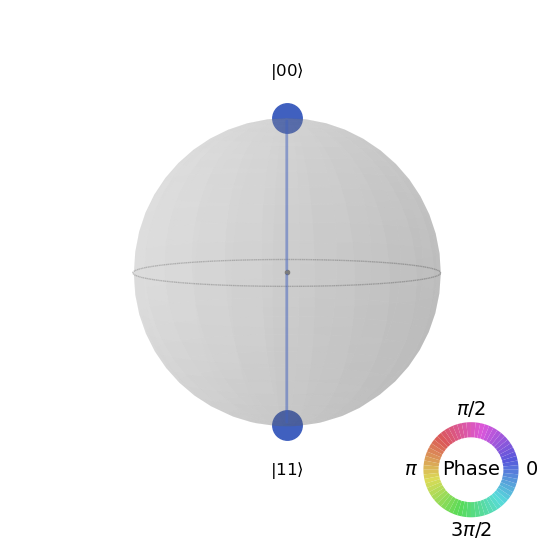

In [86]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)

plot_state_qsphere(qc)

Now let us look into the qsphere for an equal superposition of 3 qubits

In [87]:
qc = QuantumCircuit(3)
qc.h([0,1,2])

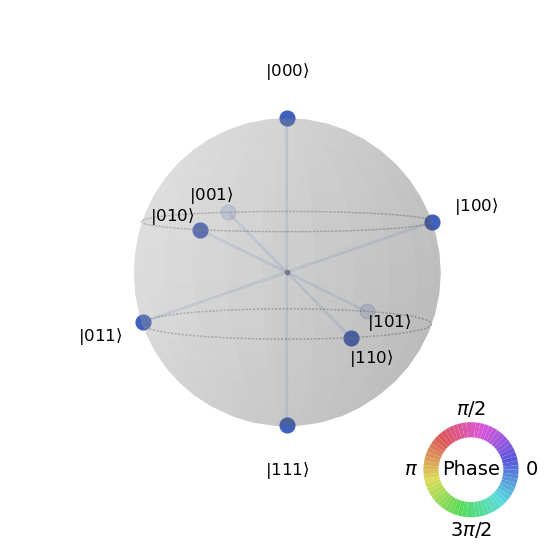

In [88]:
plot_state_qsphere(qc)

Let us add some phase to the first and second qubit

In [89]:
qc.z(0)
qc.rz(np.pi/2,1)

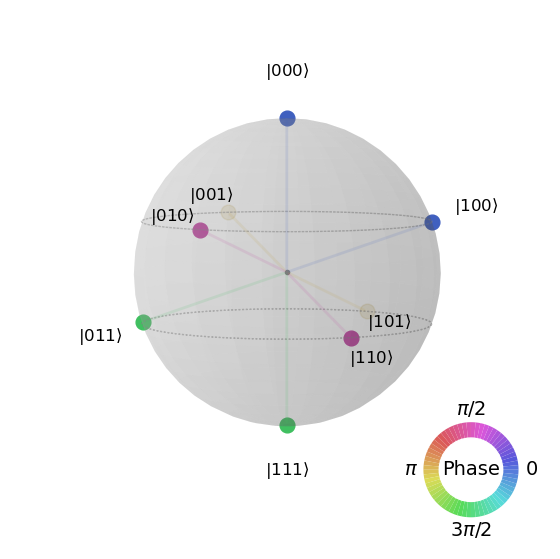

In [90]:
plot_state_qsphere(qc)

In [91]:
import qiskit.tools.jupyter
%qiskit_version_table